## Calibration Plots

We want to asses how well calibrated the detection probabilities are. To do so we genereate a calibration plot where we:
1. Bin the detections based on the confidence score predicted by the model. We split the in 10 bins: [0, 0.1, o.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1].
2. For each bin we evaluate the accuracy of the predictions computed as: $\frac{True \ pos.}{True \ pos.+False \ pos.}$ (a.k.a. the precision)
3. We plot the attained accuracy in each bin to asses if the model predicted confidence is representative of the actual model confidence

In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import pickle
import copy
from tqdm import tqdm

# set seeds for reproducibility
import torch
import random
import numpy as np

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


import os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import cv2
from scipy.stats import pearsonr, spearmanr

from src.utils.data_utils import run_length_encode
from src.model.dataset import InferenceMaskRCNNDataset, MaskRCNNDataset
from src.model.engine import FitterMaskRCNN
from src.model.model import maskRCNNModel
from src.utils.data_utils import masks_to_area, mask_to_eccentricity, masks_to_volume
from src.utils.utils import load_finetuned_weights, load_pretrained_weights

iou_thresholds = list(np.arange(0.5, 1, 0.1))
print(f"IOU thresholds: {iou_thresholds}")
bins_extremes=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = list(range(len(bins_extremes) - 1))

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


IOU thresholds: [0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999]


Load the model and the dataset

In [2]:
train_dataset_path = "../dataset/train"
val_dataset_path = "../dataset/val"
test_dataset_path = "../dataset/test"
# run the inference on the dataset
train_dataset = MaskRCNNDataset(train_dataset_path, datatype="eval")
val_dataset = MaskRCNNDataset(val_dataset_path, datatype="eval")
test_dataset = MaskRCNNDataset(test_dataset_path, datatype="eval")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn = lambda x: tuple(zip(*x)))

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = maskRCNNModel()
weights = load_finetuned_weights(device)
# weights = load_pretrained_weights(device)
model.load_state_dict(weights)
model.to(device)

engine = FitterMaskRCNN()
# We want to keep all the predictions for our analisys
train_predictions = engine.inference(model, train_loader, 0.0)
val_predictions = engine.inference(model, val_loader, 0.0)
test_predictions = engine.inference(model, test_loader, 0.0)



/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/albumentations/core/composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/Users/francesco/Documents/Work/Colorectal-Cancer-Organoids-Detection/src/utils/utils.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_o

For each prediction we check if there is a corresponding annotation or not and store the result in a dataframe

In [3]:
from scipy.optimize import linear_sum_assignment

def compute_iou(box_1, box_2):
    # compute the intersection over union of two bounding boxes
    x1 = max(box_1[0], box_2[0])
    y1 = max(box_1[1], box_2[1])
    x2 = min(box_1[2], box_2[2])
    y2 = min(box_1[3], box_2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box_1 = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    area_box_2 = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    
    union = area_box_1 + area_box_2 - intersection
    
    if union == 0:
        return 0.0
    return intersection / union

def compute_iou_matrix(bboxes_1, bboxes_2):
    # compute the iou matrix
    iou_matrix = np.zeros((len(bboxes_1), len(bboxes_2)))
    for i, box_1 in enumerate(bboxes_1):
        for j, box_2 in enumerate(bboxes_2):
            iou_matrix[i, j] = compute_iou(box_1, box_2)
    return iou_matrix


def instance_matcher(iou_matrix, iou_threshold: float = 0.5):
    # filter out the matches with low iou
    iou_matrix[iou_matrix < iou_threshold] = 0
    # Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(iou_matrix, maximize=True)
    # fileter out the matches (some of them might be an artifact of the Hungarian algorithm)
    row_ind_threshold = []
    col_ind_threshold = []
    for i, j in zip(row_ind, col_ind):
        if iou_matrix[i, j] >= iou_threshold:
            row_ind_threshold.append(i)
            col_ind_threshold.append(j)
    return row_ind_threshold, col_ind_threshold

def compute_calibration_error(bins):
    # compute the calibration score
    ce = 0.0
    for index, row in bins.iterrows():
        if row["count"] == 0:
            continue
        ce += abs(row["accuracy"] - row["confidence"]) * row["count"]
    ce /= bins["count"].sum()
    return ce

In [4]:
def process_predictions(predictions, dataset):
    predictions = copy.deepcopy(predictions)
    detections = {i: pd.DataFrame(columns=["image_id", "decetion_id", "confidence_score", "accuracy"]) for i in iou_thresholds}
    for image_id, image_predictions in tqdm(enumerate(predictions)):
        _, labels = dataset[image_id]
        iou_matrix = compute_iou_matrix(image_predictions["boxes"].cpu().numpy(), labels["boxes"].cpu().numpy())
        for iou in iou_thresholds:
            row_ind, col_ind = instance_matcher(iou_matrix, iou_threshold=iou)
            for detection_id in range(len(image_predictions["boxes"])):
                confidence_score = image_predictions["scores"][detection_id].item()
                accuracy = int(detection_id in col_ind)
                detections[iou].loc[len(detections[iou])] = [image_id, detection_id, confidence_score, accuracy]

    # plot number fo positive and negative detections
    df = pd.DataFrame(columns=["iou_threshold", "positive", "negative"])
    for iou in iou_thresholds:
        positive = detections[iou][detections[iou]["accuracy"] == 1].shape[0]
        negative = detections[iou][detections[iou]["accuracy"] == 0].shape[0]
        df.loc[len(df)] = [iou, positive, negative]
    display(df)
    return detections

print("Processing train predictions...")
train_detections = process_predictions(train_predictions, train_dataset)
print("Processing validation predictions...")
val_detections = process_predictions(val_predictions, val_dataset)
print("Processing test predictions...")
test_detections = process_predictions(test_predictions, test_dataset)   

Processing train predictions...


70it [00:11,  6.32it/s]


,iou_threshold,positive,negative
0,0.5,2765.0,2084.0
1,0.6,2697.0,2152.0
2,0.7,2508.0,2341.0
3,0.8,2008.0,2841.0
4,0.9,1256.0,3593.0


Processing validation predictions...


15it [00:02,  5.76it/s]


,iou_threshold,positive,negative
0,0.5,629.0,464.0
1,0.6,599.0,494.0
2,0.7,545.0,548.0
3,0.8,419.0,674.0
4,0.9,240.0,853.0


Processing test predictions...


15it [00:03,  4.59it/s]


,iou_threshold,positive,negative
0,0.5,802.0,512.0
1,0.6,773.0,541.0
2,0.7,694.0,620.0
3,0.8,508.0,806.0
4,0.9,287.0,1027.0


Next we look at the distribution of confidence scores

In [5]:
def plot_scores_distribution(detections: dict, dataset: str):
    labels = list(range(len(bins_extremes) - 1))  # Assuming labels are from 0 to 9
    # sns.histplot(data=detections, x = "confidence_score", bins=bins, kde=True)
    _, _, bars = plt.hist(detections[iou_thresholds[0]]["confidence_score"], bins=bins_extremes, label=labels, alpha=0.5, rwidth=0.9)
    plt.xlabel("Confidence Score")
    plt.ylabel("Number of Detections")
    plt.title(f"Distribution of Confidence Scores {dataset} Dataset")
    plt.bar_label(bars)
    plt.show()

Next we look at the calibration plot for a specific iou threshold

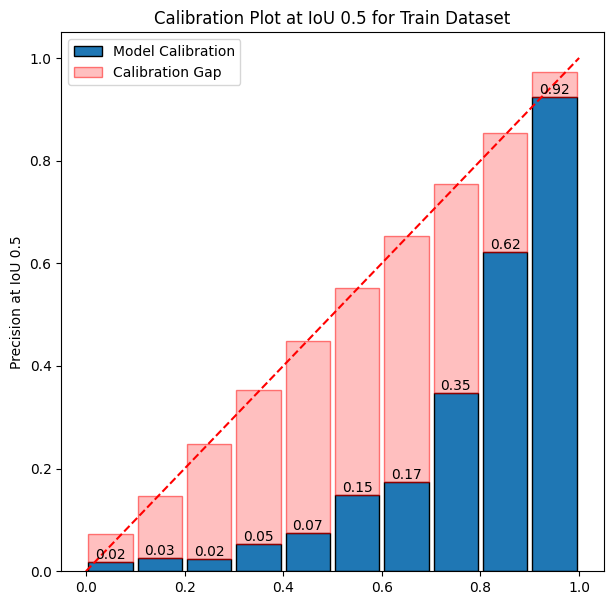

Calibration Error at IoU 0.5: 0.17


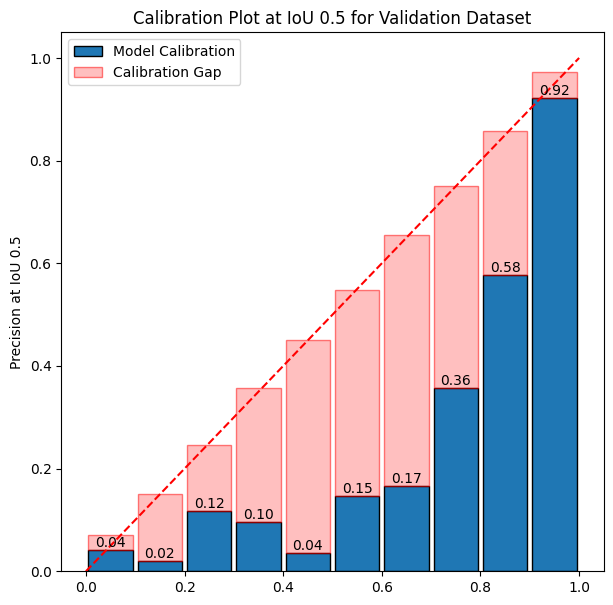

Calibration Error at IoU 0.5: 0.18


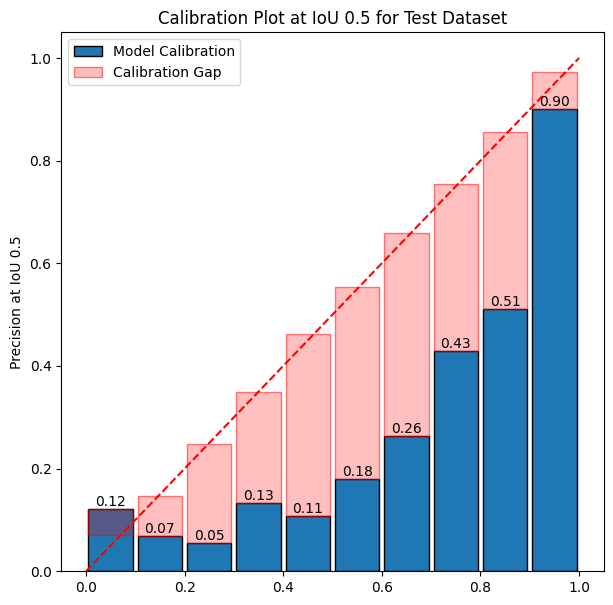

Calibration Error at IoU 0.5: 0.17


0.17420302608718063

In [6]:
def bin_predictions(detections: pd.DataFrame):
    detections = detections.copy()
    detections["bin"] = pd.cut(detections["confidence_score"], bins=bins_extremes, labels=labels)
    bins = detections.groupby("bin", observed=False)["accuracy"].mean().reset_index()
    bins["count"] = detections.groupby("bin", observed=False)["accuracy"].count().values
    bins["confidence"] = detections.groupby("bin", observed=False)["confidence_score"].mean().values
    bins["interval"] = bins_extremes[1:]
    return bins

def plot_calibration(detections: dict, dataset: str, iou: float):
    bins = bin_predictions(detections.copy())
    # sns.barplot(data=bins, x="interval", y="accuracy")
    plt.figure(figsize=(7, 7))
    
    bars = plt.bar(x=bins["interval"]- 0.05, height=bins["accuracy"], width=0.09, edgecolor='black', label='Model Calibration')
    plt.bar(x=bins["interval"]- 0.05, height=bins["confidence"] - bins["accuracy"], bottom=bins["accuracy"], color=('red', 0.25), width=0.09, label='Calibration Gap', edgecolor=('red', 0.5))
    plt.bar_label(bars, fmt='%.2f')
    # plt.bar_label(bins["accuracy"].to_list())
    plt.ylabel(f"Precision at IoU {iou}")
    plt.plot(bins_extremes, bins_extremes, color='red', linestyle='--')
    plt.legend()
    plt.title(f"Calibration Plot at IoU {iou} for {dataset} Dataset")
    plt.show()
    ce = compute_calibration_error(bins)
    print(f"Calibration Error at IoU {iou}: {ce:.2f}")
    return ce

iou = iou_thresholds[0] 
plot_calibration(train_detections[iou], "Train", iou)
plot_calibration(val_detections[iou], "Validation", iou)
plot_calibration(test_detections[iou], "Test", iou)


Generate the plot by showing all the iou thresholds simultaneously

Calibration Error at IoU 0.5: 0.17
Calibration Error at IoU 0.6: 0.19
Calibration Error at IoU 0.7: 0.23
Calibration Error at IoU 0.8: 0.33
Calibration Error at IoU 0.9: 0.48


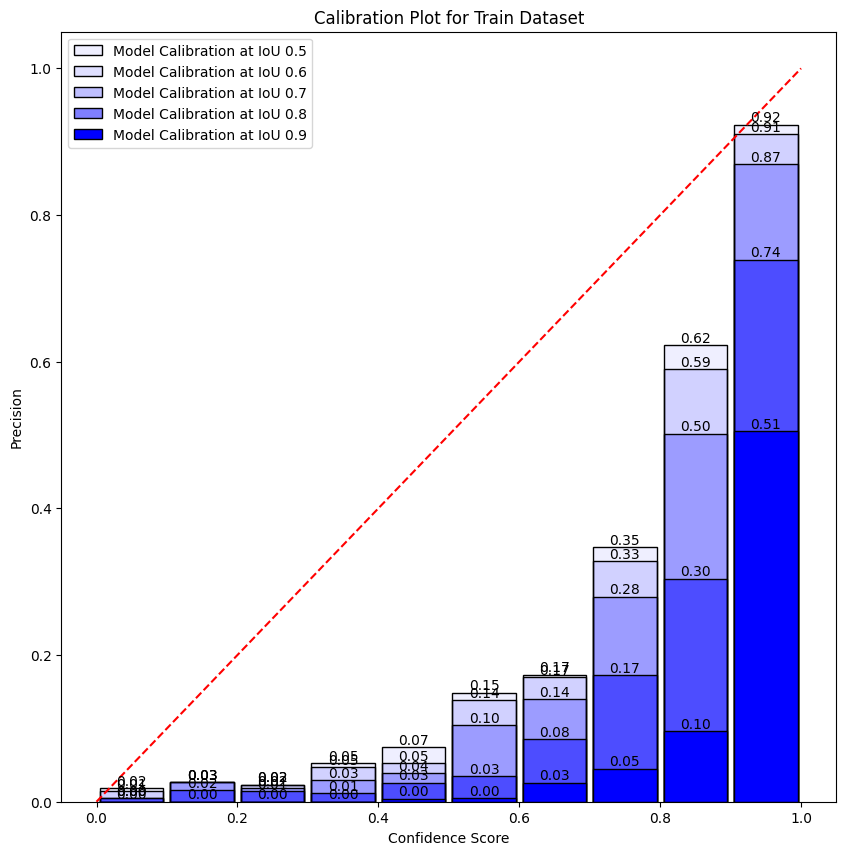

Calibration Error at IoU 0.5: 0.18
Calibration Error at IoU 0.6: 0.21
Calibration Error at IoU 0.7: 0.26
Calibration Error at IoU 0.8: 0.37
Calibration Error at IoU 0.9: 0.54


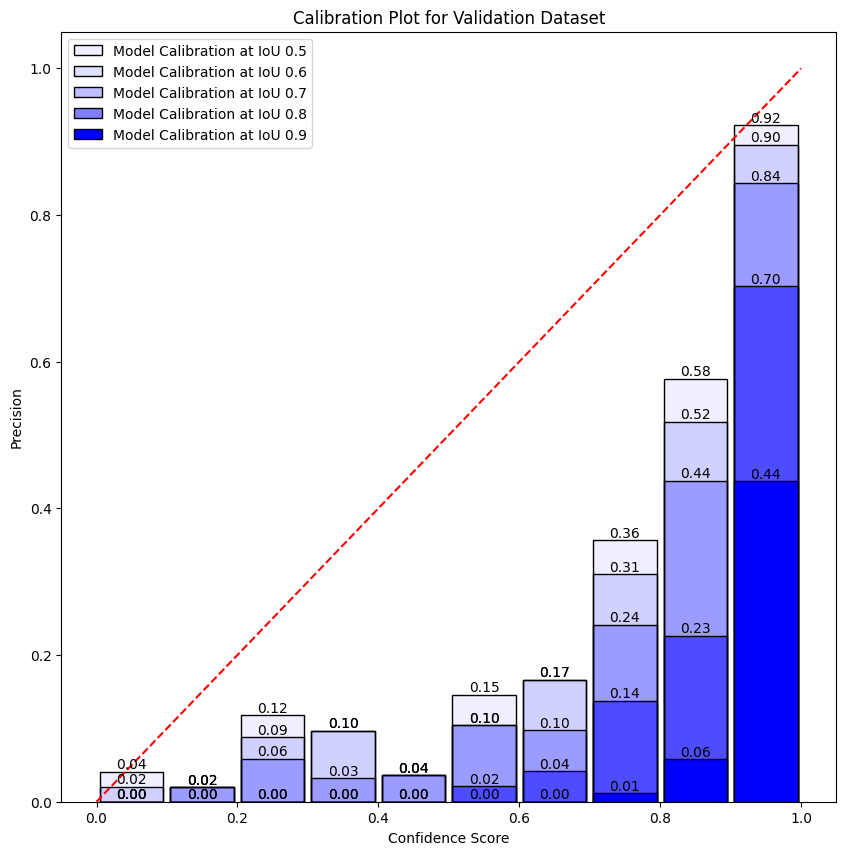

Calibration Error at IoU 0.5: 0.17
Calibration Error at IoU 0.6: 0.19
Calibration Error at IoU 0.7: 0.25
Calibration Error at IoU 0.8: 0.40
Calibration Error at IoU 0.9: 0.56


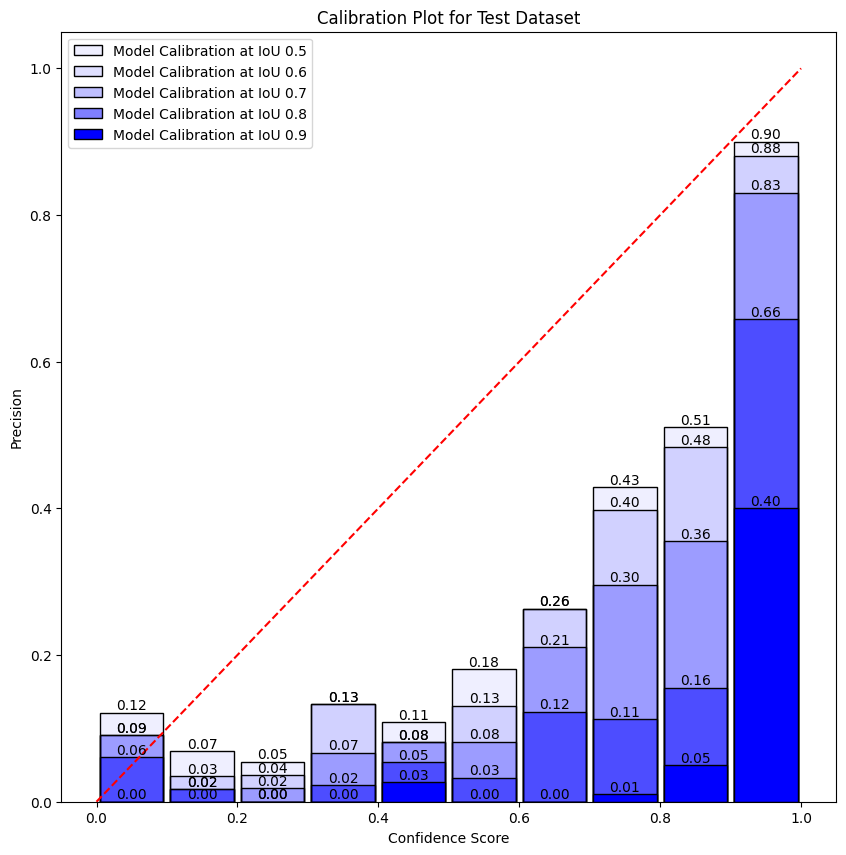

In [7]:
def plot_calibration_all(detections: dict, dataset: str):
    plt.figure(figsize=(10, 10))
    # plt.bar(x=[a - 0.05 for a in bins[1:]], height=[a - 0.05 for a in bins[1:]], color=('red', 0.25), width=0.09, label='Ideal Calibration', edgecolor=('red', 0.5))
    alpha = [1/(2**i) for i in range(len(iou_thresholds))]
    alpha = alpha[::-1]  # Reverse the order to match the iou_thresholds
    for i, iou in enumerate(iou_thresholds):
        bins = bin_predictions(detections[iou].copy())
        # sns.barplot(data=bins, x="interval", y="accuracy")
        bars = plt.bar(x=bins["interval"]- 0.05, height=bins["accuracy"], color=('blue', alpha[i]), width=0.09, edgecolor='black', label=f'Model Calibration at IoU {iou.round(2)}')
        plt.bar_label(bars, fmt='%.2f')
        # plt.bar_label(bins["accuracy"].to_list())
        ce = compute_calibration_error(bins)
        print(f"Calibration Error at IoU {iou.round(2)}: {ce:.2f}")
    plt.xlabel("Confidence Score")
    plt.title(f"Calibration Plot for {dataset} Dataset")
    plt.ylabel(f"Precision")
    plt.plot(bins_extremes, bins_extremes, color='red', linestyle='--')
    plt.legend()
    plt.show()

plot_calibration_all(train_detections, "Train")
plot_calibration_all(val_detections, "Validation")
plot_calibration_all(test_detections, "Test")

# Model recalibration

Next we try to recalibrate the model confidence scores to make them calibrated. To check if the learned non linear representation generalises beyon the dataset it was treained on, we lear the transformation on the validation set and we check if the notice and improvement on the test dataset. 

the nonlinear parametric family of tranformation we use is the following: $t(x) = 1 - (1-x^{\alpha})^{\beta}$, which for $\alpha > 0$ and $\beta > 0$ are monotonically increasing functions mapping $[0,1] \to [0,1]$.

We learn the parameter configuration that maxinizes the calibration error on the training set and evaluate whther it actually improves the calibratino error also on the test dataset, to asses if the learned transformation generalizes to unseen data.

Computing Calibration Error: 100%|██████████| 10000/10000 [00:16<00:00, 609.09it/s]

Best alpha value: (3.94, 2.223) with calibration error: 0.023656942565319024


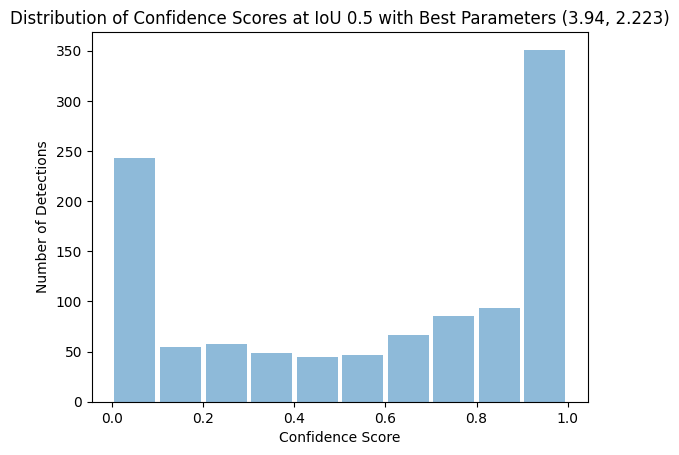

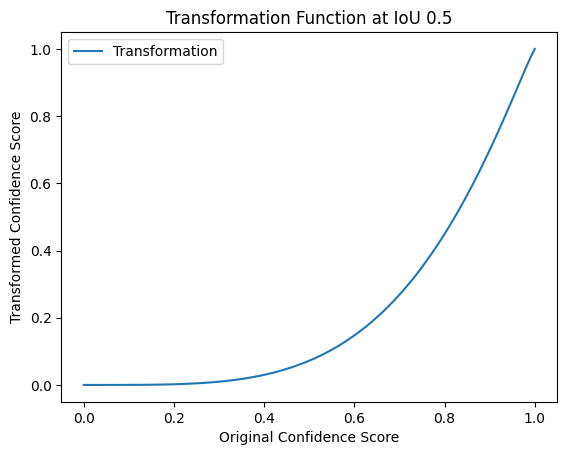

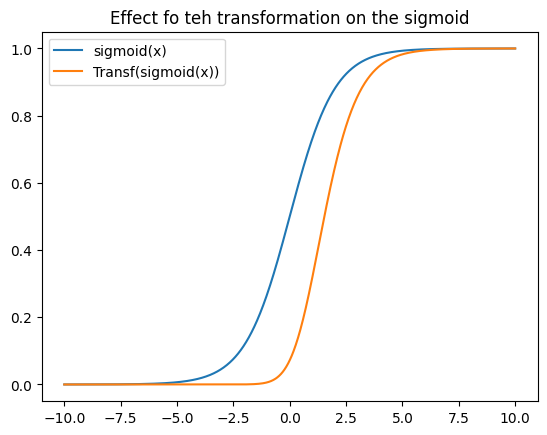

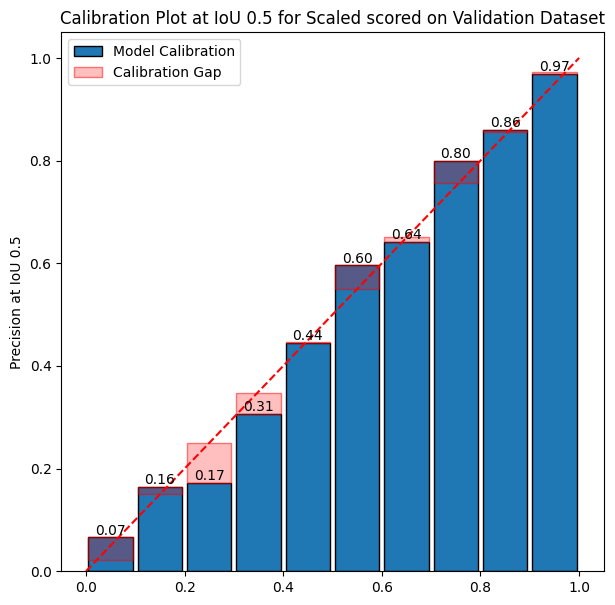

Calibration Error at IoU 0.5: 0.02


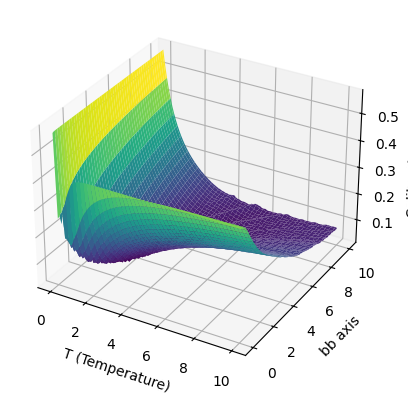

In [8]:
from tqdm import tqdm

from math import log, exp, sqrt

# class Transform:
#     "reapply sigmoid transformation with a different temperature "
#     def __init__(self, t):
#         self.t = t

#     def __call__(self, x):
#         # restore the original value before the sigmoid transformation
#         if x == 0 or x == 1:
#             return x
#         y = log(x/(1-x))
#         return 1/(1 + exp(-y/self.t))  # reapply sigmoid with temperature a
    
# class Transform2:
#     "reapply sigmoid transformation with a different temperature "
#     def __init__(self, t):
#         self.t = t

#     def __call__(self, x):
#         return max(0, 1-self.t*(1-x))  # reapply sigmoid with temperature a
    
class Transform:
    "reapply sigmoid transformation with a different temperature "
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def __call__(self, x):
        if x == 0 or x == 1:
            return x
        return 1 - sqrt(1 - x**self.a)**self.b  # reapply sigmoid with temperature a
 

iou = iou_thresholds[0]
temp = np.linspace(0.001, 10.,1000)  # Create a linear space for alpha values
aa = np.linspace(0.001, 10., 100)  # Create a linear space for alpha values
bb = np.linspace(0.001, 10., 100)  # Create a linear space for alpha values
params = [(a, b) for a in aa for b in bb]
best_param = None
best_ce = float('inf')
ce_list = []
for p in tqdm(params, desc="Computing Calibration Error"):
    a = p[0]
    b = p[1]
    # transform confidence scores
    detections_t = val_detections[iou].copy()
    detections_t["confidence_score"] = val_detections[iou]["confidence_score"].apply(Transform(a, b))  # Thresholding confidence scores
    bins = bin_predictions(detections_t)
    ce = compute_calibration_error(bins)
    ce_list.append(ce)
    if ce < best_ce:
        best_ce = ce
        best_param = (a, b)

# plot the confidence scores distribution with the best parameters
print(f"Best alpha value: {best_param} with calibration error: {best_ce}")
detections_t = val_detections[iou].copy()
detections_t["confidence_score"] = val_detections[iou]["confidence_score"].apply(Transform(*best_param))  # Thresholding confidence scores
plt.hist(detections_t["confidence_score"], bins=bins_extremes, label=labels, alpha=0.5, rwidth=0.9)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Detections")
plt.title(f"Distribution of Confidence Scores at IoU {iou} with Best Parameters {best_param}")
plt.show()

# plot the transformation function
xx = np.linspace(0, 1, 100)
yy = [Transform(*best_param)(x) for x in xx]
plt.plot(xx, yy, label=f"Transformation")
plt.xlabel("Original Confidence Score")
plt.ylabel("Transformed Confidence Score")
plt.title(f"Transformation Function at IoU {iou}")
plt.legend()
plt.show()

# plot the composition of a sigmoid and the transformation function
xx = np.linspace(-10, 10, 1000)
sigmoid = lambda x : 1/(1 + exp(-x))
yy_1 = [sigmoid(x) for x in xx]
yy_2 = [Transform(*best_param)(sigmoid(x)) for x in xx]
plt.plot(xx, yy_1, label="sigmoid(x)")
plt.plot(xx, yy_2, label=f"Transf(sigmoid(x))")
plt.title(f"Effect fo teh transformation on the sigmoid")
plt.legend()
plt.show()

# plot the calibration plot with the transformed confidence scores
plot_calibration(detections_t, "Scaled scored on Validation", iou)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(aa, bb)
Z = np.array(ce_list).reshape(len(aa), len(bb))

ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('T (Temperature)')
ax.set_ylabel('bb axis')
ax.set_zlabel('Calibration Error')

plt.show()


New we look how the learned transformation works on the test dataset. For comparison we look also at the error we would have obtained if we would have learned the transformation on the test dataset directly

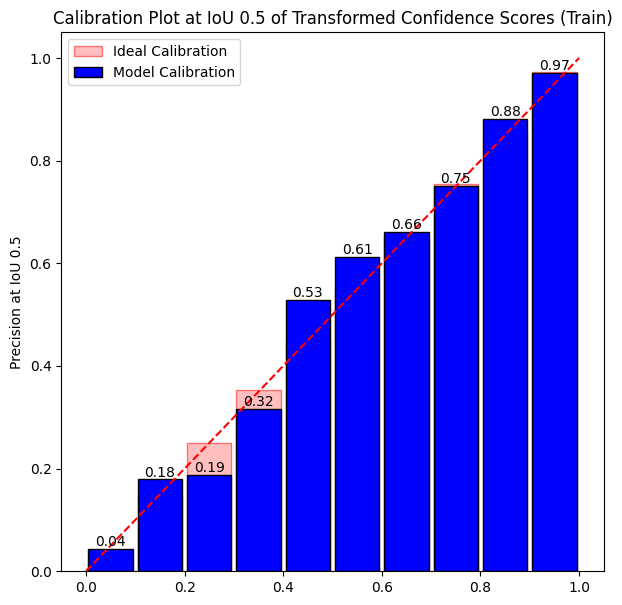

Calibration Error at IoU on Val Dataset 0.5: 0.02


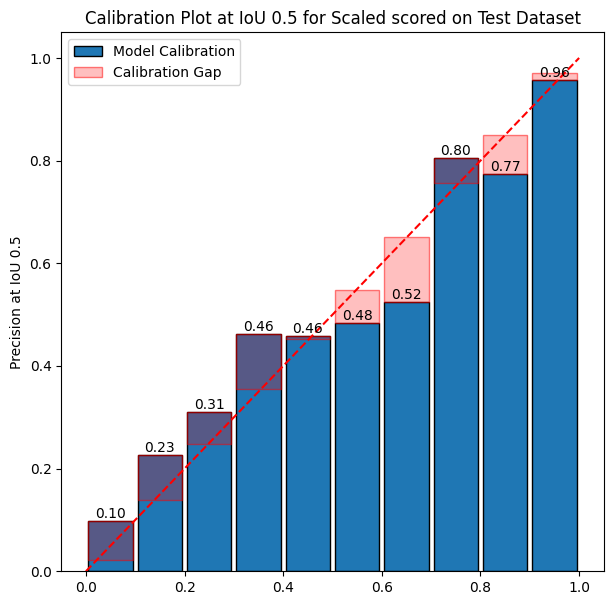

Calibration Error at IoU 0.5: 0.05
Calibration Error at IoU on Test Dataset 0.5: 0.053515934642831296


In [9]:

# plot the calibration plot for the val dataset with the best parameters
detections_t = train_detections[iou].copy()
detections_t["confidence_score"] = train_detections[iou]["confidence_score"].apply(Transform(*best_param))  # Thresholding confidence scores
bins = bin_predictions(detections_t)
plt.figure(figsize=(7, 7))
plt.bar(x=bins["interval"]- 0.05, height=bins["confidence"], color=('red', 0.25), width=0.09, label='Ideal Calibration', edgecolor=('red', 0.5))
bars = plt.bar(x=bins["interval"]- 0.05, height=bins["accuracy"], color='blue', width=0.09, edgecolor='black', label='Model Calibration')
plt.bar_label(bars, fmt='%.2f')
# plt.bar_label(bins["accuracy"].to_list())
plt.ylabel(f"Precision at IoU {iou}")
plt.plot(bins_extremes, bins_extremes, color='red', linestyle='--')
plt.title(f"Calibration Plot at IoU {iou} of Transformed Confidence Scores (Train)")
plt.legend()
plt.show()

ce = compute_calibration_error(bins)
print(f"Calibration Error at IoU on Val Dataset {iou}: {ce:.2f}")

# plot the calibration plot for the test dataset with the best parameters
detections_t = test_detections[iou].copy()
detections_t["confidence_score"] = test_detections[iou]["confidence_score"].apply(Transform(*best_param))  # Thresholding confidence scores
ce = plot_calibration(detections_t, "Scaled scored on Test", iou)


print(f"Calibration Error at IoU on Test Dataset {iou}: {ce}")

# Performance  after correction

we compare how the correction alters the model performances on the test set

In [10]:
def ap(pred_boxes, target_boxes, iou_thresholds: list):
    iou_matrix = compute_iou_matrix(pred_boxes, target_boxes)
    precision = 0.
    recall = 0.
    for iou_threshold in iou_thresholds:
        row_ind, col_ind = instance_matcher(copy.deepcopy(iou_matrix), iou_threshold)
        # filter out the matches
        tp = len(row_ind)
        fp = len(pred_boxes) - tp
        fn = len(target_boxes) - tp
        # compute the precision and recall
        precision += tp / (tp + fp) if (tp + fp) > 0 else 0
        recall += tp / (tp + fn) if (tp + fn) > 0 else 0
    precision /= len(iou_thresholds)
    recall /= len(iou_thresholds)
    return precision, recall

def map(preds, targets, iou_thresholds: list, confidece_threshold: float = 0.5):
    # compute the mean average precision
    precision = 0.
    recall = 0.
    preds = FitterMaskRCNN.filter_predicitons(preds, confidece_threshold)
    for pred, target in zip(preds, targets):
        pred_boxes = pred['boxes'].cpu().numpy()
        target_boxes = target['boxes'].cpu().numpy()
        p, r = ap(pred_boxes, target_boxes, iou_thresholds)
        precision += p
        recall += r
    precision /= len(preds)
    recall /= len(preds)
    return precision, recall

In [11]:
test_pred_transf = copy.deepcopy(test_predictions)
for p in test_pred_transf:
    p["scores"] = torch.tensor([Transform(*best_param)(s) for s in p["scores"]])
target = []
for _, t in test_dataset:
    target.append(t)

map_standard = map(
    preds=test_predictions,
    targets=target,
    iou_thresholds=np.linspace(0.5, 0.95, 10),
    confidece_threshold = 0.5,
)
map_transformed = map(
    preds=test_pred_transf,
    targets=target,
    iou_thresholds=np.linspace(0.5, 0.95, 10),
    confidece_threshold = 0.5,
)

print(f"MAP standard scores: {map_standard}")
print(f"MAP transformed scores: {map_transformed}")




MAP standard scores: (0.4521885944092442, 0.42297172748843853)
MAP transformed scores: (0.5285407286994934, 0.3675562982032574)


# Performance invariant transformation

we lear a permutation that leaves the preformances unchanged, ie t(0.5) = 0.5 if the confidence threshold is 0.5

Computing Calibration Error: 100%|██████████| 100/100 [00:00<00:00, 594.34it/s]

Best alpha value: 0.506 with calibration error: 0.15542457906541157


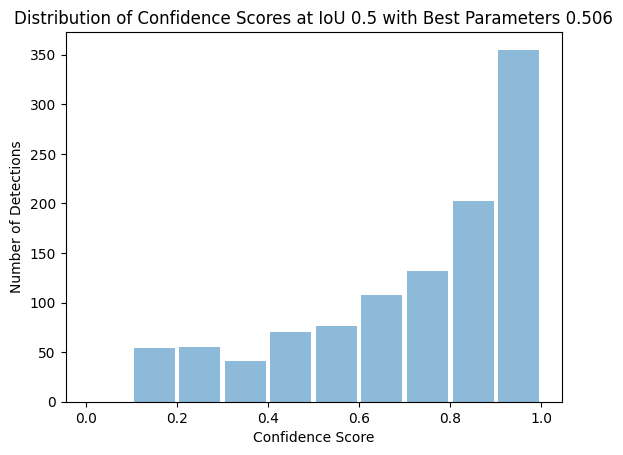

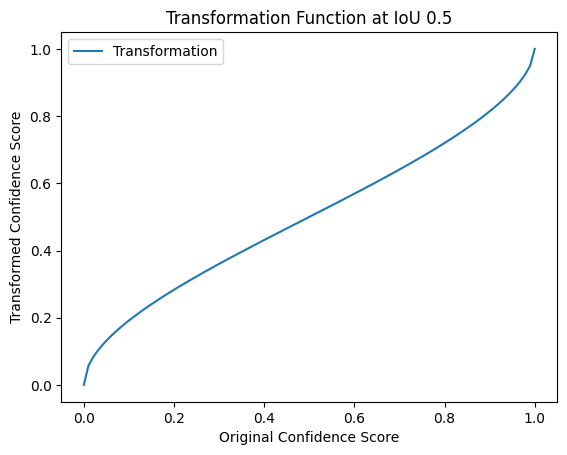

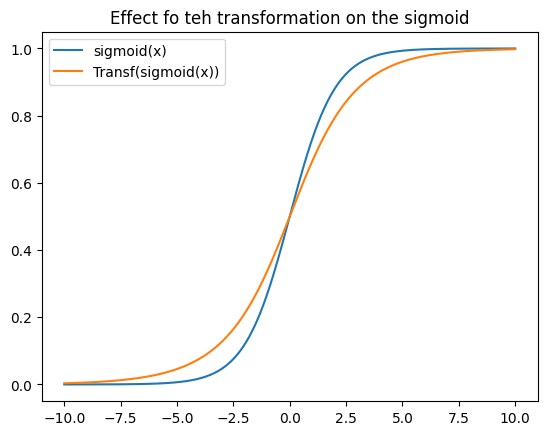

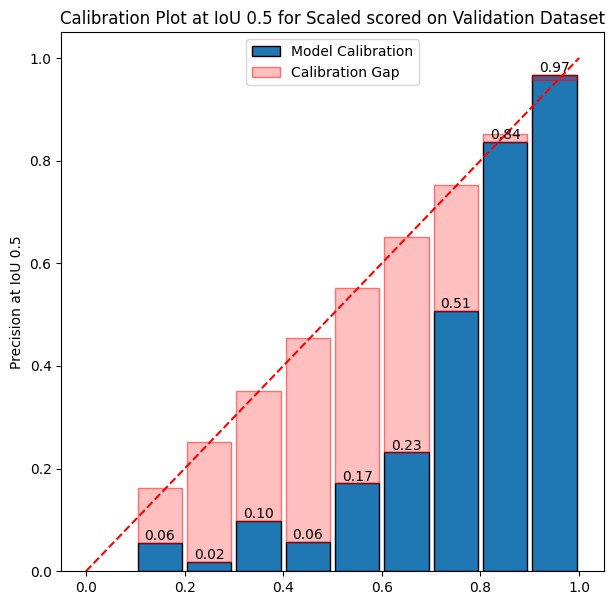

Calibration Error at IoU 0.5: 0.16


0.15542457906541157

In [12]:
from tqdm import tqdm

from math import log, exp, sqrt

    
class Transform2:
    "reapply sigmoid transformation with a different temperature "
    def __init__(self, a, p):
        # p i the fixed point score
        self.a = a
        self.p = p
        self.b = log(1-p)/log(1-p**a)

    def __call__(self, x):
        if x == 0 or x == 1:
            return x
        return 1 - (1 - x**self.a)**self.b  # reapply sigmoid with temperature a
 

iou = iou_thresholds[0]
aa = np.linspace(0.001, 10., 100)  # Create a linear space for alpha values
p = 0.5
best_a = None
best_ce = float('inf')
ce_list = []
for a in tqdm(aa, desc="Computing Calibration Error"):
    # transform confidence scores
    detections_t = val_detections[iou].copy()
    detections_t["confidence_score"] = val_detections[iou]["confidence_score"].apply(Transform2(a, p))  # Thresholding confidence scores
    bins = bin_predictions(detections_t)
    ce = compute_calibration_error(bins)
    ce_list.append(ce)
    if ce < best_ce:
        best_ce = ce
        best_a = a

# plot the confidence scores distribution with the best parameters
print(f"Best alpha value: {best_a} with calibration error: {best_ce}")
detections_t = val_detections[iou].copy()
detections_t["confidence_score"] = val_detections[iou]["confidence_score"].apply(Transform2(best_a, p))  # Thresholding confidence scores
plt.hist(detections_t["confidence_score"], bins=bins_extremes, label=labels, alpha=0.5, rwidth=0.9)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Detections")
plt.title(f"Distribution of Confidence Scores at IoU {iou} with Best Parameters {best_a}")
plt.show()

# plot the transformation function
xx = np.linspace(0, 1, 100)
yy = [Transform2(best_a, p)(x) for x in xx]
plt.plot(xx, yy, label=f"Transformation")
plt.xlabel("Original Confidence Score")
plt.ylabel("Transformed Confidence Score")
plt.title(f"Transformation Function at IoU {iou}")
plt.legend()
plt.show()

# plot the composition of a sigmoid and the transformation function
xx = np.linspace(-10, 10, 1000)
sigmoid = lambda x : 1/(1 + exp(-x))
yy_1 = [sigmoid(x) for x in xx]
yy_2 = [Transform2(best_a, p)(sigmoid(x)) for x in xx]
plt.plot(xx, yy_1, label="sigmoid(x)")
plt.plot(xx, yy_2, label=f"Transf(sigmoid(x))")
plt.title(f"Effect fo teh transformation on the sigmoid")
plt.legend()
plt.show()

# plot the calibration plot with the transformed confidence scores
plot_calibration(detections_t, "Scaled scored on Validation", iou)


## Platt scaling

Fitted parameters: a=7.447962181952145, b=-5.541186370632122


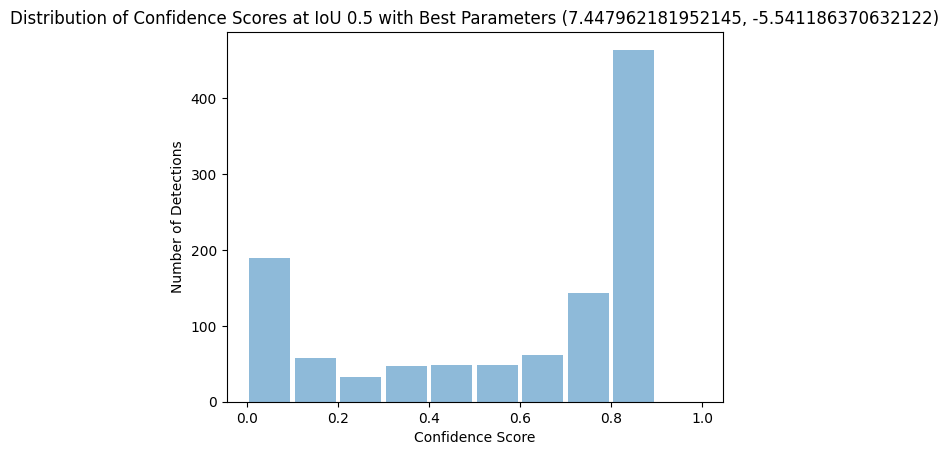

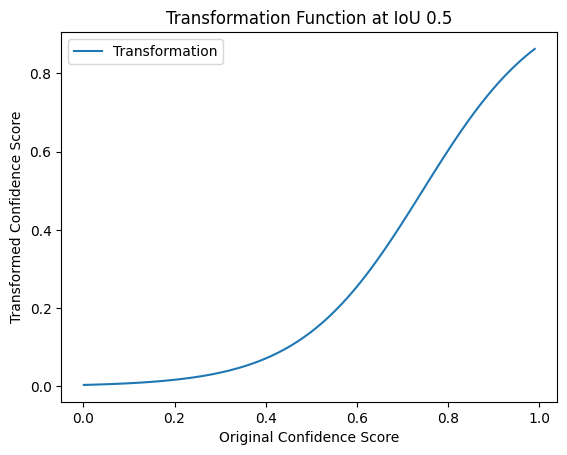

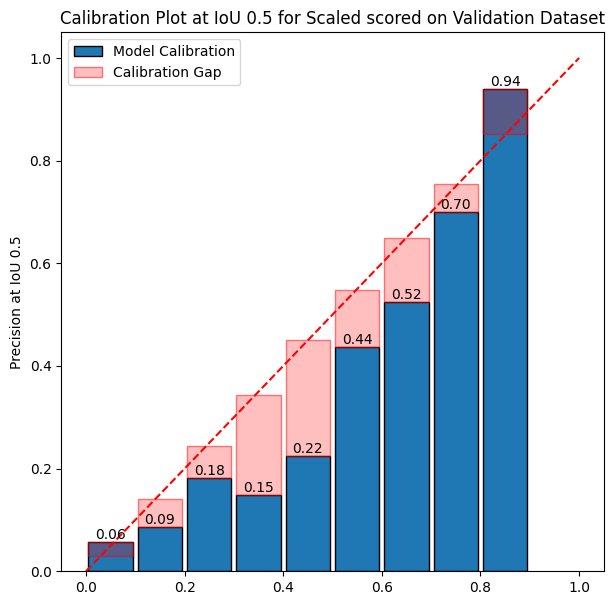

Calibration Error at IoU 0.5: 0.08


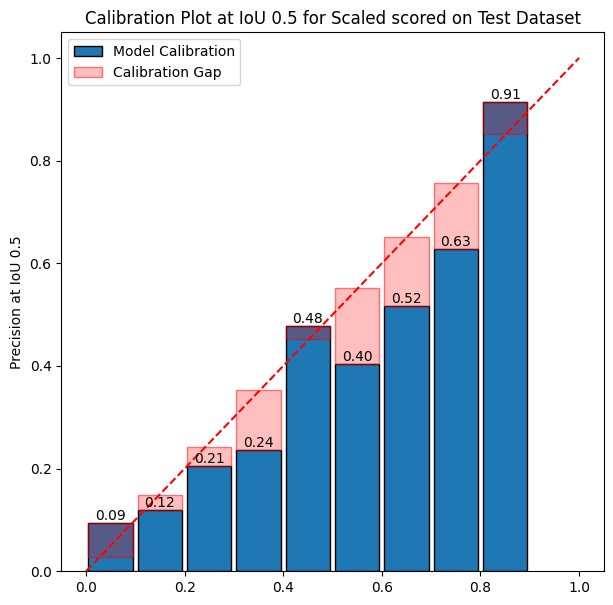

Calibration Error at IoU 0.5: 0.08


In [13]:

iou = iou_thresholds[0]
best_metric = float('inf')
metric_list = []
val_scores = val_detections[iou]["confidence_score"].to_numpy()
# expand a dimensions
val_scores = np.expand_dims(val_scores, axis=1)
val_targets = val_detections[iou]["accuracy"].to_numpy()

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(val_scores, val_targets)
# get the fitted parameters
a,b = model.coef_[0][0], model.intercept_[0]
print(f"Fitted parameters: a={a}, b={b}")
cal_val_scores = model.predict_proba(val_scores)[:, 1]

# plot the confidence scores distribution with the best parameters
plt.hist(cal_val_scores, bins=bins_extremes, label=labels, alpha=0.5, rwidth=0.9)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Detections")
plt.title(f"Distribution of Confidence Scores at IoU {iou} with Best Parameters {a,b}")
plt.show()

# # plot the transformation function
xx = np.linspace(0.001, 0.99, 100)
yy = model.predict_proba(np.expand_dims(xx, axis=1))[:, 1]
plt.plot(xx, yy, label=f"Transformation")
plt.xlabel("Original Confidence Score")
plt.ylabel("Transformed Confidence Score")
plt.title(f"Transformation Function at IoU {iou}")
plt.legend()
plt.show()

# # plot the composition of a sigmoid and the transformation function
# xx = np.linspace(-10, 10, 1000)
# sigmoid = lambda x : 1/(1 + exp(-x))
# yy_1 = [sigmoid(x) for x in xx]
# yy_2 = [Transform(*best_param)(sigmoid(x)) for x in xx]
# plt.plot(xx, yy_1, label="sigmoid(x)")
# plt.plot(xx, yy_2, label=f"Transf(sigmoid(x))")
# plt.title(f"Effect fo teh transformation on the sigmoid")
# plt.legend()
# plt.show()

# # plot the calibration plot with the transformed confidence scores
detections_t = val_detections[iou].copy()
detections_t["confidence_score"] = cal_val_scores  # Thresholding confidence scores
plot_calibration(detections_t, "Scaled scored on Validation", iou)
# plot_calibration(detections_t, "Scaled scored on Validation", iou)

# plot the calibration plot for the test dataset with the best parameters
test_scores = test_detections[iou]["confidence_score"].to_numpy()
cal_test_scores = model.predict_proba(np.expand_dims(test_scores, axis=1))[:, 1]
detections_t = test_detections[iou].copy()
detections_t["confidence_score"] = cal_test_scores  # Thresholding confidence scores
ce = plot_calibration(detections_t, "Scaled scored on Test", iou)


platt scaling starting from the raw logits

Fitted parameters: a=1.2054129767712793, b=-1.8946207488923683


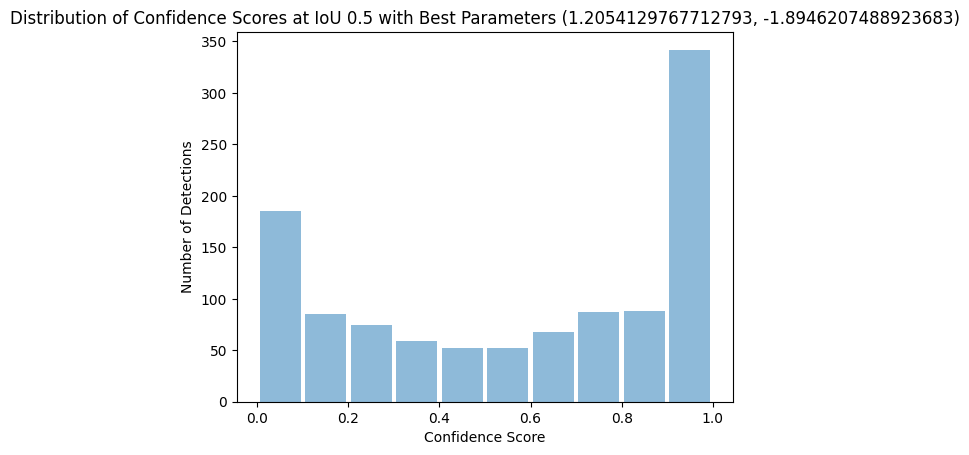

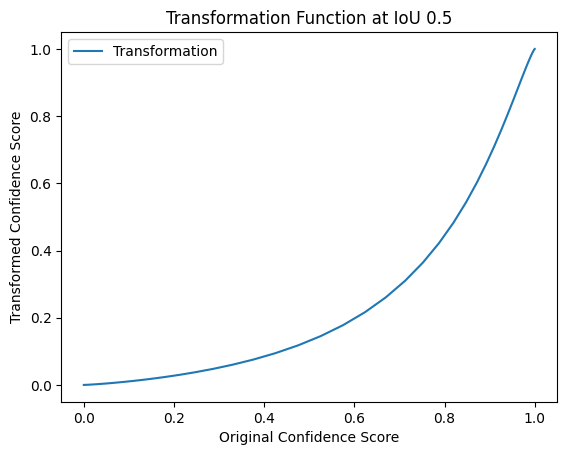

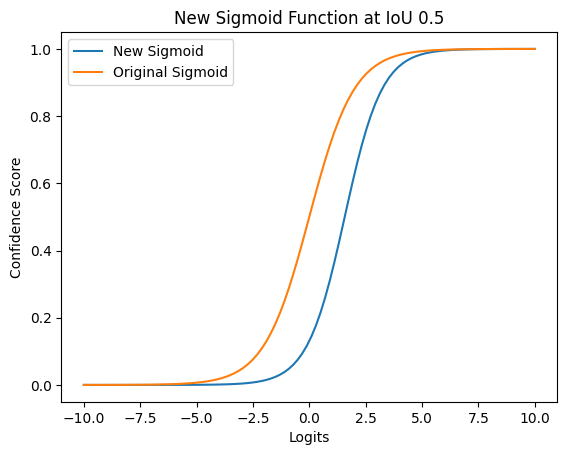

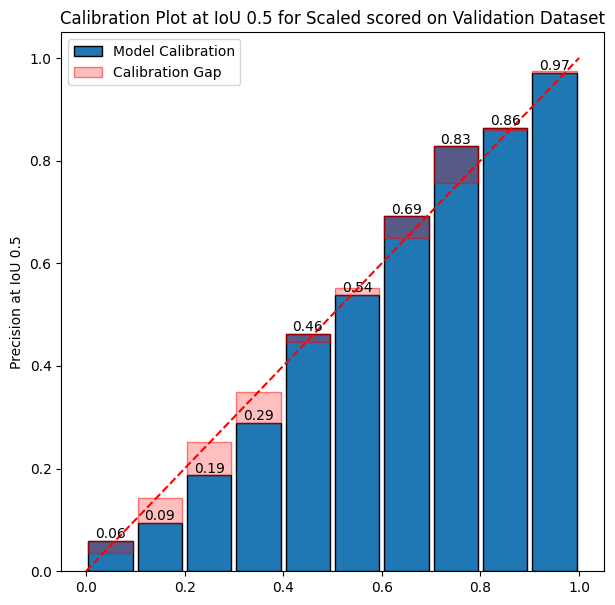

Calibration Error at IoU 0.5: 0.03


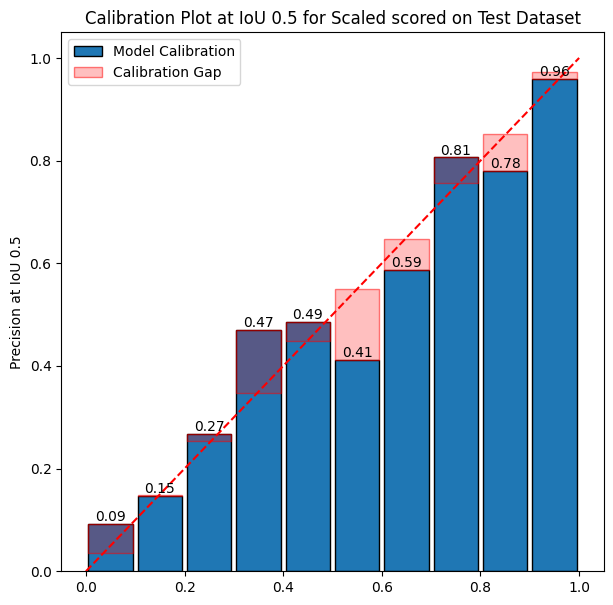

Calibration Error at IoU 0.5: 0.04


In [14]:

iou = iou_thresholds[0]
best_metric = float('inf')
metric_list = []
val_scores = val_detections[iou]["confidence_score"].to_numpy()
val_logits = np.log(val_scores / (1 - val_scores + 1e-15) + 1e-15)
# expand a dimensions
val_logits = np.expand_dims(val_logits, axis=1)
val_targets = val_detections[iou]["accuracy"].to_numpy()

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(val_logits, val_targets)
# get the fitted parameters
a,b = model.coef_[0][0], model.intercept_[0]
print(f"Fitted parameters: a={a}, b={b}")
cal_val_scores = model.predict_proba(val_logits)[:, 1]

# plot the confidence scores distribution with the best parameters
plt.hist(cal_val_scores, bins=bins_extremes, label=labels, alpha=0.5, rwidth=0.9)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Detections")
plt.title(f"Distribution of Confidence Scores at IoU {iou} with Best Parameters {a,b}")
plt.show()


# # plot the transformation function
logits = np.linspace(-10, 10, 100)
yy = model.predict_proba(np.expand_dims(logits, axis=1))[:, 1]
xx = 1/(1 + np.exp(-logits))
plt.plot(xx, yy, label=f"Transformation")
plt.xlabel("Original Confidence Score")
plt.ylabel("Transformed Confidence Score")
plt.title(f"Transformation Function at IoU {iou}")
plt.legend()
plt.show()

# plot the new sigmoid function
plt.plot(logits, yy, label="New Sigmoid")
plt.plot(logits, 1/(1 + np.exp(-logits)), label="Original Sigmoid")
plt.xlabel("Logits")
plt.ylabel("Confidence Score")
plt.title(f"New Sigmoid Function at IoU {iou}")
plt.legend()
plt.show()

# # plot the composition of a sigmoid and the transformation function
# xx = np.linspace(-10, 10, 1000)
# sigmoid = lambda x : 1/(1 + exp(-x))
# yy_1 = [sigmoid(x) for x in xx]
# yy_2 = [Transform(*best_param)(sigmoid(x)) for x in xx]
# plt.plot(xx, yy_1, label="sigmoid(x)")
# plt.plot(xx, yy_2, label=f"Transf(sigmoid(x))")
# plt.title(f"Effect fo teh transformation on the sigmoid")
# plt.legend()
# plt.show()

# # plot the calibration plot with the transformed confidence scores
detections_t = val_detections[iou].copy()
detections_t["confidence_score"] = cal_val_scores  # Thresholding confidence scores
plot_calibration(detections_t, "Scaled scored on Validation", iou)
# plot_calibration(detections_t, "Scaled scored on Validation", iou)

# plot the calibration plot for the test dataset with the best parameters
test_scores = test_detections[iou]["confidence_score"].to_numpy()
test_logits = np.log(test_scores / (1 - test_scores + 1e-15) + 1e-15)
cal_test_scores = model.predict_proba(np.expand_dims(test_logits, axis=1))[:, 1]
detections_t = test_detections[iou].copy()
detections_t["confidence_score"] = cal_test_scores  # Thresholding confidence scores
ce = plot_calibration(detections_t, "Scaled scored on Test", iou)


# Beta calibration

(1093, 2)
Fitted parameters: a=0.41609726583689927, b=1.4599890891449765, c=-2.6074639282726655


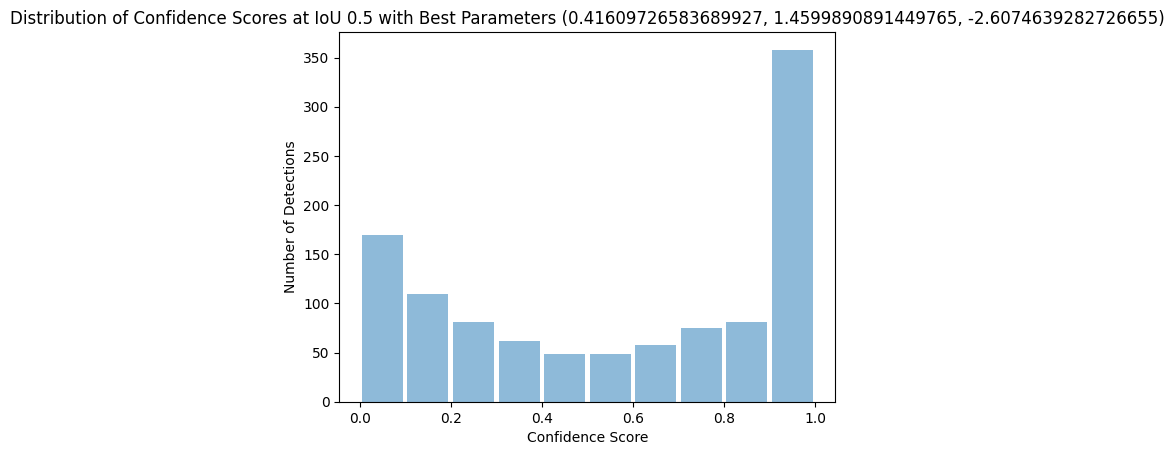

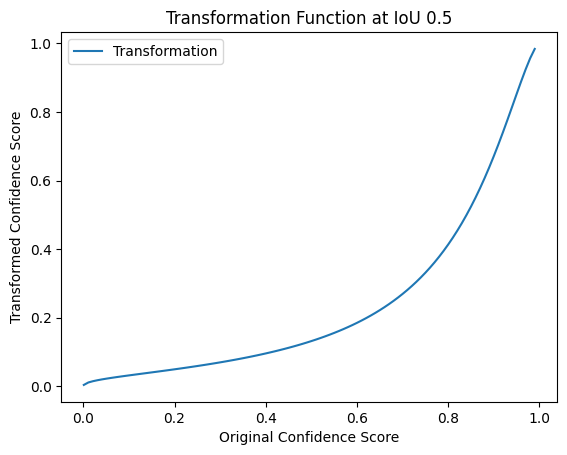

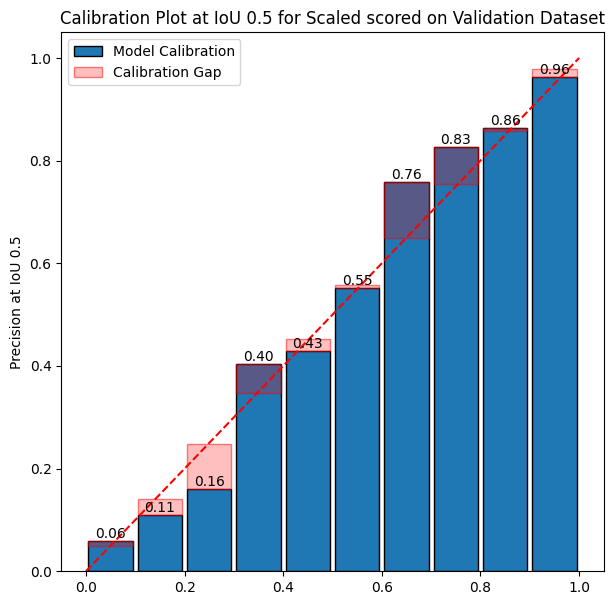

Calibration Error at IoU 0.5: 0.03


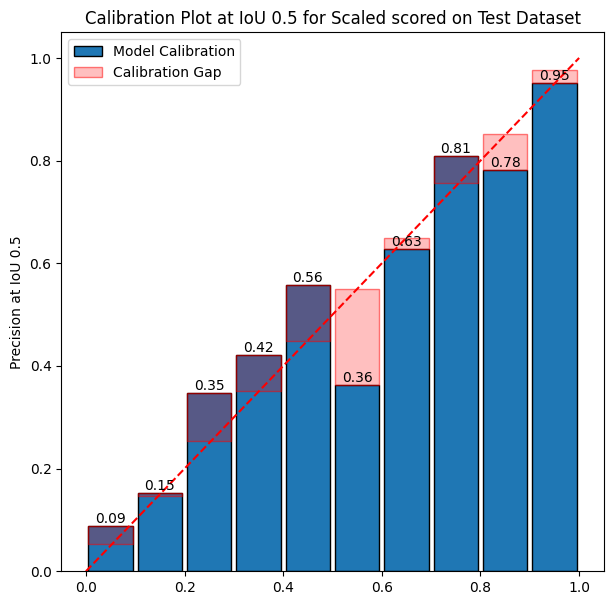

Calibration Error at IoU 0.5: 0.05


In [15]:

iou = iou_thresholds[0]
best_metric = float('inf')
metric_list = []
val_scores = val_detections[iou]["confidence_score"].to_numpy()
val_targets = val_detections[iou]["accuracy"].to_numpy()

features = np.array([[np.log(s), -np.log(1.0 - s)] for s in val_scores])
print(features.shape)
from sklearn.linear_model import LogisticRegression
model_beta = LogisticRegression()
model_beta.fit(features, val_targets)
# get the fitted parameters
a,b,c = model_beta.coef_[0][0], model_beta.coef_[0][1], model_beta.intercept_[0]
print(f"Fitted parameters: a={a}, b={b}, c={c}")
cal_val_scores = model_beta.predict_proba(features)[:, 1]

# plot the confidence scores distribution with the best parameters
plt.hist(cal_val_scores, bins=bins_extremes, label=labels, alpha=0.5, rwidth=0.9)
plt.xlabel("Confidence Score")
plt.ylabel("Number of Detections")
plt.title(f"Distribution of Confidence Scores at IoU {iou} with Best Parameters {a,b,c}")
plt.show()

# # plot the transformation function
xx = np.linspace(0.001, 0.99, 100)
yy = model_beta.predict_proba(np.array([[np.log(x), -np.log(1.0 - x)] for x in xx]))[:, 1]
plt.plot(xx, yy, label=f"Transformation")
plt.xlabel("Original Confidence Score")
plt.ylabel("Transformed Confidence Score")
plt.title(f"Transformation Function at IoU {iou}")
plt.legend()
plt.show()

# # plot the composition of a sigmoid and the transformation function
# xx = np.linspace(-10, 10, 1000)
# sigmoid = lambda x : 1/(1 + exp(-x))
# yy_1 = [sigmoid(x) for x in xx]
# yy_2 = [Transform(*best_param)(sigmoid(x)) for x in xx]
# plt.plot(xx, yy_1, label="sigmoid(x)")
# plt.plot(xx, yy_2, label=f"Transf(sigmoid(x))")
# plt.title(f"Effect fo teh transformation on the sigmoid")
# plt.legend()
# plt.show()

# # plot the calibration plot with the transformed confidence scores
detections_t = val_detections[iou].copy()
detections_t["confidence_score"] = cal_val_scores  # Thresholding confidence scores
plot_calibration(detections_t, "Scaled scored on Validation", iou)
# plot_calibration(detections_t, "Scaled scored on Validation", iou)

# plot the calibration plot for the test dataset with the best parameters
test_scores = test_detections[iou]["confidence_score"].to_numpy()
test_targets = test_detections[iou]["accuracy"].to_numpy()
test_features = np.array([[np.log(s), -np.log(1.0 - s)] for s in test_scores])
cal_test_scores = model_beta.predict_proba(test_features)[:, 1]
detections_t = test_detections[iou].copy()
detections_t["confidence_score"] = cal_test_scores  # Thresholding confidence scores
ce = plot_calibration(detections_t, "Scaled scored on Test", iou)


## PLot ROC curve

forst we plot it with standard socres and with corrected scores

/Users/francesco/miniconda3/envs/colorec/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


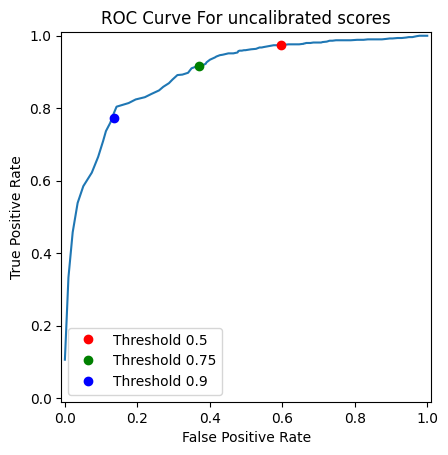

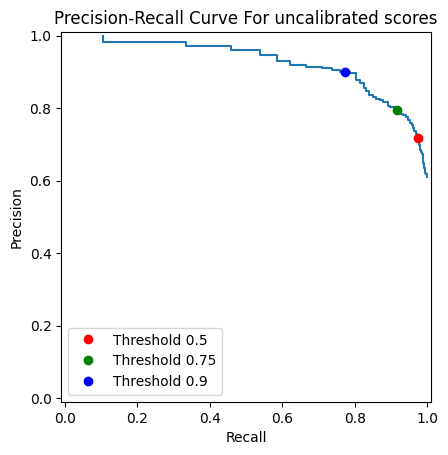

In [16]:
confidence_thresholds = np.linspace(0.001, 0.999, 100)
confidence_thresholds = np.concatenate((confidence_thresholds, [0.5, 0.75, 0.9]))
tpr = []
fpr = []
precision = []
recall = []
iou = iou_thresholds[0]
detections = test_detections[iou]
for conf in confidence_thresholds:
    tp = detections[(detections["confidence_score"] >= conf) & (detections["accuracy"] == 1)].shape[0]
    fp = detections[(detections["confidence_score"] >= conf) & (detections["accuracy"] == 0)].shape[0]
    fn = detections[(detections["confidence_score"] < conf) & (detections["accuracy"] == 1)].shape[0]
    tn = detections[(detections["confidence_score"] < conf) & (detections["accuracy"] == 0)].shape[0]
    tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

import sklearn
display = sklearn.metrics.RocCurveDisplay(fpr=fpr[:-3], tpr=tpr[:-3])
display.plot()
plt.plot(fpr[-3], tpr[-3], 'ro', label='Threshold 0.5')
plt.plot(fpr[-2], tpr[-2], 'go', label='Threshold 0.75')
plt.plot(fpr[-1], tpr[-1], 'bo', label='Threshold 0.9')
plt.legend()
plt.title(f"ROC Curve For uncalibrated scores")
plt.show()

display = sklearn.metrics.PrecisionRecallDisplay(precision=precision[:-3], recall=recall[:-3])
display.plot()
plt.title(f"Precision-Recall Curve For uncalibrated scores")
plt.plot(recall[-3], precision[-3], 'ro', label='Threshold 0.5')
plt.plot(recall[-2], precision[-2], 'go', label='Threshold 0.75')
plt.plot(recall[-1], precision[-1], 'bo', label='Threshold 0.9')
plt.legend()
plt.show()

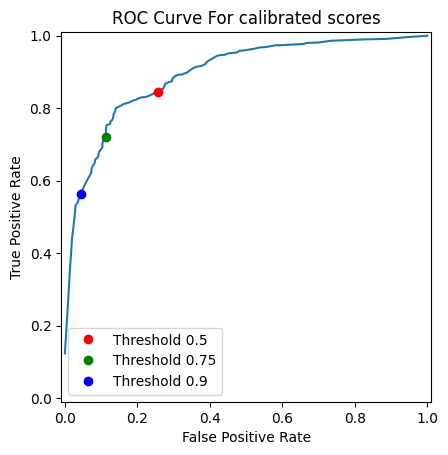

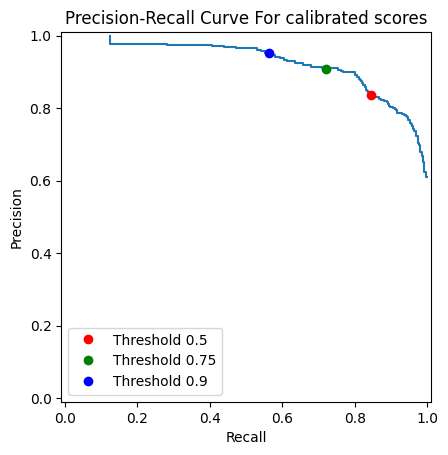

In [17]:
confidence_thresholds = np.linspace(0.001, 0.999, 100)
confidence_thresholds = np.concatenate((confidence_thresholds, [0.5, 0.75, 0.9]))
tpr = []
fpr = []
precision = []
recall = []
iou = iou_thresholds[0]
detections = detections_t
for conf in confidence_thresholds:
    tp = detections[(detections["confidence_score"] >= conf) & (detections["accuracy"] == 1)].shape[0]
    fp = detections[(detections["confidence_score"] >= conf) & (detections["accuracy"] == 0)].shape[0]
    fn = detections[(detections["confidence_score"] < conf) & (detections["accuracy"] == 1)].shape[0]
    tn = detections[(detections["confidence_score"] < conf) & (detections["accuracy"] == 0)].shape[0]
    tpr.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    fpr.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
    precision.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    recall.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

import sklearn
display = sklearn.metrics.RocCurveDisplay(fpr=fpr[:-3], tpr=tpr[:-3])
display.plot()
plt.plot(fpr[-3], tpr[-3], 'ro', label='Threshold 0.5')
plt.plot(fpr[-2], tpr[-2], 'go', label='Threshold 0.75')
plt.plot(fpr[-1], tpr[-1], 'bo', label='Threshold 0.9')
plt.legend()
plt.title(f"ROC Curve For calibrated scores")
plt.show()


display = sklearn.metrics.PrecisionRecallDisplay(precision=precision[:-3], recall=recall[:-3])
display.plot()
plt.title(f"Precision-Recall Curve For calibrated scores")
plt.plot(recall[-3], precision[-3], 'ro', label='Threshold 0.5')
plt.plot(recall[-2], precision[-2], 'go', label='Threshold 0.75')
plt.plot(recall[-1], precision[-1], 'bo', label='Threshold 0.9')
plt.legend()
plt.show()